In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [46]:
import projetLib as proj
import torch
from tqdm import tqdm
import sys
from statistics import mean
from torch import nn
from torchmetrics import ConfusionMatrix,Accuracy
import os
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss, HingeEmbeddingLoss
import numpy as np

In [5]:
base = "./data" + "/images/"
unzipped = "./Virusshare.00457/"
proj.extract_features(unzipped,base)

Extracting features: 100%|██████████| 10681/10681 [11:40<00:00, 15.24it/s] 


In [3]:
runName = "smallpe_2"
batch_size = 16
limit = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 1

trainDataset, testDataset = proj.image.getTrainTest(
    resize=(224,224), batch_size=batch_size, seed=1, limit=limit,
    test_proportion=0.2, extensions=["other"])

model =  proj.model.getCNNresnet().to(device)
trainloader = DataLoader(trainDataset, num_workers=2, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testDataset, num_workers=2, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

# tuples de loss et leur coef
losses = [
    #(imp.loss.perceptualVGG,1),
    #(imp.loss.totalVariation,1),
    (BCEWithLogitsLoss(),1)
    # (HingeEmbeddingLoss(),1)
]

In [4]:
proj.process.train_malware(model, optimizer, trainloader, losses, testloader, runName=runName, epochs=epochs)

Training loss: 8.50557:  12%|██▏               | 37/298 [00:27<01:40,  2.60it/s]


Training loss: 8.52817:  26%|████▌             | 76/298 [00:42<01:25,  2.58it/s]


Training loss: 8.36664:  38%|██████▌          | 114/298 [00:57<01:11,  2.56it/s]


Training loss: 8.15435:  51%|████████▋        | 153/298 [01:12<00:56,  2.56it/s]


Training loss: 7.99916:  64%|██████████▉      | 191/298 [01:27<00:42,  2.55it/s]


Training loss: 6.96468:  77%|█████████████    | 230/298 [01:42<00:26,  2.55it/s]


Training loss: 5.97631:  90%|███████████████▎ | 268/298 [01:58<00:11,  2.53it/s]


Training loss: 5.41275: 100%|█████████████████| 298/298 [02:09<00:00,  2.21it/s]
                                                                                
Testing progress:  21%|█████▎                   | 16/76 [00:02<00:09,  6.53it/s]


Testing progress:  99%|████████████████████████▋| 75/76 [00:11<00:00,  7.83it/s]
smallpe_2 - Epoch 1/1, Accuracy 100.0000%, Recall nan%, Precision nan%, Loss : 5


In [47]:
accuracy = Accuracy(task="binary",num_classes=2).to(device)

In [83]:
l=np.array([])
acc=[]
with torch.no_grad():
    t1 = tqdm(testloader, desc=f"Testing progress", colour="#005500", leave=False) 
    for x, y in t1 : 
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        outputs = nn.Sigmoid()(outputs)
        outputs = torch.reshape(outputs,(len(y),))
        print(outputs.cpu().data.numpy())
        l = np.concatenate((l,outputs.cpu().data.numpy()))
        acc+=[accuracy(outputs,y).tolist()]


Testing progress:   3%|▋                         | 2/76 [00:00<00:17,  4.13it/s]

[0.9982437  0.9982015  0.9982653  0.99999976 1.         0.9979322
 0.9982875  0.99831223 0.9982817  0.99831957 0.9975313  0.99835676
 0.9982711  0.9983668  1.         0.9982742 ]
[0.99830866 0.9983895  0.9886596  0.99827945 0.9982153  0.99837565
 0.99815124 1.         0.9983342  0.99825114 0.9982407  0.99826175
 0.99810046 0.99823904 0.99704957 0.9982058 ]


Testing progress:   5%|█▎                        | 4/76 [00:00<00:11,  6.09it/s]

[0.99833506 1.         0.99836725 1.         1.         0.998348
 0.9982333  0.998425   0.99770963 0.99830365 0.99818146 0.9982369
 0.9983165  0.99999905 0.99822384 0.9983981 ]
[0.99824834 0.998276   0.9983077  1.         0.9982862  0.99823546
 0.99842983 0.99836177 1.         0.9983437  1.         0.9962031
 0.99824995 0.998314   0.9982337  0.9982324 ]


Testing progress:   8%|██                        | 6/76 [00:01<00:09,  7.16it/s]

[0.9982638  0.99836737 0.9984042  0.99829394 0.99836284 0.99821824
 0.9982843  0.99819654 1.         0.9982526  0.99828666 0.99837047
 0.998362   1.         0.99827874 1.        ]
[0.99826777 0.99836737 0.9981833  0.9982632  0.99818414 1.
 0.9983524  0.99829274 0.99834776 0.99837047 0.9982651  0.9984037
 0.9982388  0.9983315  0.99751174 0.9982298 ]


Testing progress:  11%|██▋                       | 8/76 [00:01<00:08,  7.69it/s]

[0.9983028  0.998285   0.9982653  0.9981029  0.99826247 0.99827254
 0.99826294 0.9981988  0.9999994  0.9981627  0.9983242  0.9982564
 0.9982116  0.9982128  0.99827635 1.        ]
[0.9982431  0.9980884  1.         0.99831104 0.998251   0.99828017
 0.998254   0.9971204  0.9983255  0.9982224  1.         0.9982943
 0.9982529  0.99827325 0.99822706 0.9983005 ]


Testing progress:  13%|███▎                     | 10/76 [00:01<00:08,  7.93it/s]

[0.9983211  0.9983277  0.99831533 0.9982331  0.99825245 0.99833846
 0.99834645 0.9983292  0.99831414 0.99828416 1.         0.9981875
 1.         1.         0.9982805  0.9981828 ]
[0.99838626 0.99823856 0.9983028  0.9983163  0.9982805  0.9999981
 0.998259   0.99823195 0.99536186 0.9982799  1.         0.9976361
 0.99823534 1.         0.99824023 1.        ]


Testing progress:  16%|███▉                     | 12/76 [00:01<00:07,  8.06it/s]

[0.99831617 0.99799156 1.         0.9983485  0.9982338  0.99821305
 0.99614584 0.9983714  0.99831104 0.99831796 0.998212   0.9982457
 0.9981255  1.         0.99826175 0.9982735 ]
[0.9983571  1.         0.9982615  0.99814296 1.         0.9982963
 0.99754447 0.9983125  0.9983088  0.99832124 0.9983352  0.99827385
 0.998151   0.99806947 0.99817216 0.99825567]


Testing progress:  18%|████▌                    | 14/76 [00:02<00:07,  8.10it/s]

[0.9983668  0.9982632  0.9984035  0.9982755  0.99838424 0.9982875
 0.99834704 0.99831414 0.99832994 0.99824214 0.9983499  0.9982399
 0.998345   0.99827576 0.9982376  0.99835074]
[0.9982685  0.9983992  0.99829346 0.99835795 0.99831307 0.99829286
 0.9982925  0.9983677  0.99820375 0.9983517  1.         0.9983619
 0.9983399  0.998326   0.9983329  0.9983247 ]


Testing progress:  21%|█████▎                   | 16/76 [00:02<00:07,  8.16it/s]

[0.99840945 0.9982992  0.9984169  1.         1.         0.9983164
 0.99828124 0.9983448  0.9978573  0.99824774 0.9982974  0.99831605
 0.99831796 0.9983027  0.99999976 0.99814904]
[0.99838126 0.9983431  1.         0.99830353 1.         0.99999857
 0.9982803  0.9983728  0.9982083  0.99828583 0.99826944 0.9984484
 0.9982799  0.9982141  0.9983847  0.9982828 ]


Testing progress:  24%|█████▉                   | 18/76 [00:02<00:07,  8.17it/s]

[0.99818295 0.9983382  1.         0.9983639  0.99827564 0.9983601
 0.9982886  0.9982552  0.9983026  0.99834764 0.9999982  1.
 0.99830014 0.99832445 0.99826956 0.99827623]
[0.99794906 0.9982357  0.9983205  0.9982968  0.99834216 0.998357
 0.99764985 1.         0.9984003  0.99829024 0.99827874 0.9982147
 0.99826175 0.9982582  0.9982633  0.9983094 ]


Testing progress:  26%|██████▌                  | 20/76 [00:02<00:06,  8.15it/s]

[0.99825186 0.99829346 0.9977284  0.9982351  0.99817955 0.9984003
 0.9982845  0.9982103  0.9815408  1.         0.99806386 0.9983103
 1.         0.99821174 0.998075   0.9983138 ]
[0.99828255 0.99823207 0.99830294 0.9999478  1.         0.9983516
 0.99837697 0.9967964  1.         0.99832267 0.9983455  0.998024
 0.99825996 0.9983292  1.         0.99828774]


Testing progress:  29%|███████▏                 | 22/76 [00:02<00:06,  8.09it/s]

[0.90158516 1.         0.99592435 1.         1.         0.9982436
 0.9982566  0.9982247  0.998185   0.99822444 0.9982262  0.9982413
 0.99830085 0.9982634  0.9981698  0.9983285 ]
[0.998315   0.9983078  1.         0.9980116  0.99823844 0.99838805
 0.9983924  0.9980539  0.9977642  0.9983259  0.9982293  0.9982039
 0.99825305 0.99820316 0.9983114  0.99830174]


Testing progress:  32%|███████▉                 | 24/76 [00:03<00:06,  8.13it/s]

[0.9982413  0.998309   0.99819607 0.998315   0.9983936  1.
 0.99824464 1.         1.         0.9984249  0.9981918  0.9982564
 0.99834    0.99832636 0.9316842  0.99829   ]
[0.9981382  0.9982078  0.99827576 0.9983121  0.99827707 0.998302
 0.99837106 0.99826354 0.9982577  0.9983058  0.99803597 0.99829227
 0.9982326  1.         0.9982889  0.99762934]


Testing progress:  34%|████████▌                | 26/76 [00:03<00:06,  8.12it/s]

[0.99824834 0.9982936  1.         0.99832577 1.         0.998403
 0.9968104  0.99821067 0.9864655  0.99831057 0.9982572  1.
 0.99787736 0.9983272  0.997224   0.9983164 ]
[0.998351   0.9983071  0.998271   0.99834263 0.99828136 0.9982461
 0.9983962  0.9983531  0.9983095  0.9983565  0.998168   0.998279
 0.9999999  0.99825495 0.9983376  0.99836046]


Testing progress:  37%|█████████▏               | 28/76 [00:03<00:05,  8.12it/s]

[0.9983367  0.9982665  1.         0.9997141  0.9983631  0.998264
 0.9983632  0.99833244 0.9981565  1.         0.99999774 0.99836606
 0.9983929  0.99825317 0.9982685  0.99824643]
[0.9982455  1.         0.9983543  1.         0.9982533  0.9979818
 0.9972082  0.99837625 0.9983557  0.9981939  1.         0.9982717
 0.9981579  1.         0.99836975 0.99822897]


Testing progress:  39%|█████████▊               | 30/76 [00:03<00:05,  8.12it/s]

[0.9983583  0.9983004  0.99825746 1.         0.9982553  0.99829704
 0.9982899  0.9983158  0.9982198  0.9981346  0.99824667 0.9983602
 0.9983053  1.         0.99826694 0.9982975 ]
[0.99826103 0.99831855 0.99828005 0.99838185 0.9983967  0.9982698
 0.99831605 0.9982893  0.9982476  0.99818534 0.9980959  0.9982988
 1.         0.99840266 0.9982426  0.9968749 ]


Testing progress:  42%|██████████▌              | 32/76 [00:04<00:05,  8.16it/s]

[1.         0.99827754 0.9982509  0.99838436 0.9983015  0.9982596
 0.99828196 0.9983175  0.99829453 0.99834883 0.9983309  1.
 0.9982712  0.99835086 0.9999925  1.        ]
[0.9982596  1.         0.998372   1.         0.9983417  0.99816895
 0.9528077  0.9976914  0.9983668  0.9983327  0.99828845 0.98666465
 0.99827003 0.998251   0.9982893  0.9983033 ]


Testing progress:  45%|███████████▏             | 34/76 [00:04<00:06,  6.29it/s]

[0.9982817  0.9983506  0.99829966 0.9983529  0.99837625 0.9983658
 1.         1.         0.9982918  0.99825674 0.99807596 0.99831307
 0.99816954 0.9983468  0.99759066 1.        ]
[1.         0.9983084  0.9982685  0.9983026  1.         0.99834573
 0.9983322  0.99828964 0.99838114 0.99825126 0.99823064 0.998268
 0.99820733 0.9983796  0.9983084  0.99835026]


Testing progress:  47%|███████████▊             | 36/76 [00:04<00:05,  7.13it/s]

[0.99827313 0.9982692  0.9983005  0.9983394  1.         0.99832755
 0.9978702  0.99826103 0.99831945 0.99820125 0.9982843  1.
 0.99826247 1.         0.99832815 0.9983822 ]
[0.9982497  0.9982687  0.9983138  0.9982711  0.9983084  0.9982351
 0.9982931  0.99831235 0.99827695 0.9982664  0.99833834 0.99840313
 0.9982502  0.9982998  0.99818265 0.99830747]


Testing progress:  50%|████████████▌            | 38/76 [00:05<00:04,  7.64it/s]

[0.9983498  0.9983651  0.9564527  0.9983563  0.9982457  1.
 0.9962812  0.9983156  0.9982139  0.99834144 1.         0.9983053
 0.9982697  0.99999213 0.9959045  0.998376  ]
[0.99842703 0.9982633  0.9983485  1.         0.9983132  1.
 0.99831223 0.998317   0.9981439  0.99830604 0.9982703  0.99826694
 0.998206   0.9984022  0.9982607  0.99831235]


Testing progress:  53%|█████████████▏           | 40/76 [00:05<00:04,  7.89it/s]

[1.         0.9984205  0.998387   0.99825984 1.         0.9982673
 0.9982699  0.9983316  0.9983317  0.9982803  0.99825805 0.9983491
 0.99832493 1.         0.9983569  0.9982919 ]
[0.99827576 0.99823713 0.99834335 0.9982303  0.99753916 0.9982949
 0.9982558  0.9982799  0.99806494 0.9975962  0.9999995  0.9983364
 0.99753165 1.         0.9983229  0.99833447]


Testing progress:  55%|█████████████▊           | 42/76 [00:05<00:04,  8.04it/s]

[0.9984073  0.9983113  0.9983935  0.9982291  0.99999666 0.99833506
 0.99825174 0.9983126  0.99578035 0.9983463  0.99831593 0.9982212
 1.         1.         0.9983204  0.9983323 ]
[0.9982273  0.9982844  0.99834096 0.99824536 1.         0.9984157
 0.9983058  0.9982857  0.9982779  0.99827516 0.9982351  0.99999905
 0.9982622  0.9983407  0.99822444 1.        ]


Testing progress:  58%|██████████████▍          | 44/76 [00:05<00:03,  8.11it/s]

[0.99836105 0.9982672  0.9982497  0.99832433 0.9982212  1.
 0.9982339  0.9983022  0.9981857  0.9983102  0.9982645  0.99832636
 1.         1.         0.9999999  0.9983059 ]
[0.9983936  0.99831474 0.9981438  0.9982627  0.9983224  0.9981869
 0.99825424 0.99786514 0.9982515  0.9982476  0.998409   0.9999956
 0.99832183 0.9983658  0.99835014 0.9980823 ]


Testing progress:  61%|███████████████▏         | 46/76 [00:06<00:03,  8.15it/s]

[0.9981976  0.9982205  0.9983694  0.9983354  0.9982261  0.99762744
 1.         0.99826056 0.9983164  0.99835455 0.9983571  0.9982534
 0.9983082  0.99820864 0.9983388  0.9982994 ]
[0.99828905 0.9971834  0.99828917 0.99831605 0.99830973 0.99830806
 0.99811304 0.998338   0.9982699  0.99825317 1.         0.99830854
 0.99829465 0.99822587 0.99838936 0.9983197 ]


Testing progress:  63%|███████████████▊         | 48/76 [00:06<00:03,  8.15it/s]

[0.9982768  0.99829155 0.9983352  0.99832624 0.99835676 0.9981351
 1.         0.99832386 0.9983424  0.9983543  0.9982974  0.9962269
 0.9980242  0.99824655 0.9981908  1.        ]
[0.998279   0.9981742  0.99830794 0.9983158  1.         0.99826825
 0.9977527  0.9976943  0.99828243 0.99828786 0.9982857  0.9981767
 0.9982317  0.9982621  0.99830914 0.9983329 ]


Testing progress:  66%|████████████████▍        | 50/76 [00:06<00:03,  8.13it/s]

[0.9983713  0.9999995  0.99833256 1.         1.         0.9961606
 0.99824727 0.99827874 0.99831676 1.         0.9983051  0.99812406
 0.9982224  0.9983908  0.9982697  0.9977069 ]
[1.         0.99833494 0.99828184 0.99831676 1.         0.9982932
 1.         0.99834013 0.9984106  0.9983139  0.99815035 0.9983151
 0.99828315 0.9960128  0.9983374  0.9983644 ]


Testing progress:  68%|█████████████████        | 52/76 [00:06<00:02,  8.11it/s]

[1.         1.         0.9999999  0.99827635 0.99823016 0.9983668
 0.9981865  0.99812096 0.99591994 1.         0.91984504 0.99819463
 0.9982811  0.9982666  0.99778605 0.9981248 ]
[0.9983027  0.99829024 0.9983284  0.9975114  0.9982436  0.99829155
 0.9999851  0.9983309  0.9982919  0.99828964 0.9983163  1.
 0.9983613  0.9999994  0.9983052  0.99824536]


Testing progress:  71%|█████████████████▊       | 54/76 [00:07<00:02,  8.13it/s]

[0.9982389  1.         0.9982786  0.9983406  0.9981938  0.9983102
 0.9982079  1.         0.9982089  0.99826616 1.         0.9982337
 0.99828243 0.99829084 0.99831665 0.99837327]
[0.9982942  0.9983192  1.         0.9983192  0.99835265 0.99829096
 1.         1.         0.99829394 0.9982547  1.         0.9982248
 0.9983254  0.9982768  0.9982426  0.99822897]


Testing progress:  74%|██████████████████▍      | 56/76 [00:07<00:02,  8.15it/s]

[0.9983662  0.99820864 0.9981768  0.9982205  0.99817896 0.9983695
 0.9983588  0.9983259  0.99825555 1.         0.9983463  0.99830425
 0.9971539  0.9983531  0.9983575  0.99828845]
[0.99999976 0.9982944  0.998334   1.         0.9982653  0.99837095
 0.9977041  0.99830014 1.         1.         0.9983505  0.9983681
 0.9982668  0.99823844 1.         0.9983047 ]


Testing progress:  76%|███████████████████      | 58/76 [00:07<00:02,  8.15it/s]

[0.9983216  0.99837226 0.9982205  0.99812466 0.9982809  1.
 0.99826425 0.9982576  0.9980934  0.9983589  0.9982803  0.9983187
 0.9982191  0.9982778  0.9982016  0.9975375 ]
[1.         0.9983424  0.998278   1.         0.9983498  0.99999726
 0.9982023  0.9983064  0.99826825 0.9982881  0.9983261  1.
 0.99828196 0.9982974  0.99829    0.9982851 ]


Testing progress:  79%|███████████████████▋     | 60/76 [00:07<00:01,  8.16it/s]

[0.99794406 0.99828464 0.9982665  0.99829024 0.99824643 0.9983524
 0.99825567 0.9983846  0.99822706 0.99822134 0.99827397 0.99830234
 0.99827766 0.99830914 0.9982901  0.9983518 ]
[1.         0.998273   0.9984048  0.9983681  0.99829787 0.99826103
 0.99830604 0.99830663 0.99833494 0.99836725 0.99826556 0.998317
 1.         0.998357   0.99833006 0.99825937]


Testing progress:  82%|████████████████████▍    | 62/76 [00:08<00:01,  8.16it/s]

[0.99833316 1.         0.99827003 0.9983298  0.99999976 0.99832386
 0.9982821  0.9983109  0.99819833 0.9982545  0.99825686 0.9983839
 0.9981212  0.99816847 0.99820995 0.9983285 ]
[0.9983871  0.99834514 0.99684626 0.99822575 0.99825925 0.99834275
 0.998126   0.9981184  0.9999999  0.99828136 0.99828416 0.99825054
 0.998273   1.         0.99836546 0.9983266 ]


Testing progress:  84%|█████████████████████    | 64/76 [00:08<00:01,  8.17it/s]

[0.9976382  0.99833715 1.         1.         0.99826103 0.99828476
 1.         0.9983197  0.99830866 0.9982551  0.9982091  0.9983082
 0.99837375 0.99822384 0.9982747  1.        ]
[0.99827135 0.99819034 0.99832135 0.9981665  0.9983134  0.9983228
 0.99824464 0.9983164  0.99822754 0.99833775 0.99834263 0.9982526
 0.9981957  0.9958824  0.9983046  0.99828976]


Testing progress:  87%|█████████████████████▋   | 66/76 [00:08<00:01,  8.16it/s]

[0.9984012  0.9982722  0.99827313 1.         0.9983552  1.
 0.9980908  0.998314   0.998123   0.9982482  0.99825007 0.9983789
 0.99825007 0.9983677  0.99837035 0.9983498 ]
[0.99841046 0.99999857 0.9983006  0.9983498  0.9983537  0.9982717
 1.         0.9978765  0.9982718  0.9982711  0.9999999  0.9982957
 0.9983045  0.9983828  0.99829537 0.99807215]


Testing progress:  89%|██████████████████████▎  | 68/76 [00:08<00:00,  8.17it/s]

[0.9981602  1.         0.9983386  1.         1.         0.9983505
 0.9980787  0.9984145  0.9983242  0.99831414 1.         0.9983164
 0.9982601  0.9984143  0.99831843 0.9982875 ]
[1.         0.9983333  0.99824893 0.9981363  0.99842274 1.
 0.9983552  0.998317   0.99831104 0.99827945 0.9983125  0.99832135
 0.9981887  1.         0.99836725 0.9983418 ]


Testing progress:  92%|███████████████████████  | 70/76 [00:09<00:00,  8.16it/s]

[0.99832386 0.99829334 0.9982502  0.99827623 0.9982316  0.9976191
 0.99826753 0.9982377  0.9982216  0.9975956  1.         1.
 0.99825484 0.9982974  0.99830484 0.9982564 ]
[0.9982241  0.99817324 0.9980563  0.9983059  0.99942553 0.9983942
 0.99818087 0.9982798  0.9983602  0.99830085 0.96252805 0.99816835
 0.99828076 0.9982986  1.         0.9982292 ]


Testing progress:  95%|███████████████████████▋ | 72/76 [00:09<00:00,  8.15it/s]

[0.9982868  0.9982529  0.9982772  0.99826235 0.9982773  0.99843615
 0.9982495  0.9981818  1.         0.9983291  1.         0.9982331
 0.998248   0.99833506 0.99829    0.9983766 ]
[0.9982577  0.9983272  0.99820757 0.9982712  0.9982261  0.9983134
 0.9981963  0.9983169  0.99783677 0.998309   0.9983224  0.9983072
 0.9982951  0.9982602  0.9982267  0.99999976]


Testing progress:  97%|████████████████████████▎| 74/76 [00:09<00:00,  8.11it/s]

[0.9982735  0.99835455 0.9982023  0.99840873 0.998326   0.99835193
 0.9983197  0.9982949  0.9982663  0.99833184 0.9981231  1.
 0.9983798  0.99781185 0.99830484 0.9983321 ]
[0.9983658  0.9983187  0.9982844  0.99827635 0.9983543  0.9962127
 0.99762446 0.997528   0.9983039  0.9976653  0.99831605 0.9982383
 0.99778926 0.9983541  0.99833363 0.9980533 ]


                                                                                <00:00,  8.17it/s]

[1.         0.998204   0.9982326  0.99826825 1.         0.9974304
 0.9981078  0.9983847  0.9981439  0.9983279  0.998166   0.99827504
 0.9982615  0.9982657  0.9981225  0.9982268 ]
[0.99834    1.         0.99749315]


In [6]:
!python3 -m pip install -U matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 kB 11.4 MB/s eta 0:00:00


In [35]:
import matplotlib.pyplot as plt

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [92]:
print(l)
a=set(map(lambda x:truncate(x,3),l))
print(a)
c=list(map(lambda x:truncate(x,3),l))
x,y=[],[]
for i in a:
    x+=[i]
    y+=[c.count(i)]
print(x,y)

[0.99824369 0.99820149 0.99826533 ... 0.99834001 1.         0.99749315]
{0.998, 0.999, 0.997, 1.0, 0.988, 0.996, 0.995, 0.981, 0.901, 0.931, 0.952, 0.919, 0.986, 0.962, 0.956}
[0.998, 0.999, 0.997, 1.0, 0.988, 0.996, 0.995, 0.981, 0.901, 0.931, 0.952, 0.919, 0.986, 0.962, 0.956] [952, 30, 49, 145, 1, 11, 6, 1, 1, 1, 1, 1, 2, 1, 1]


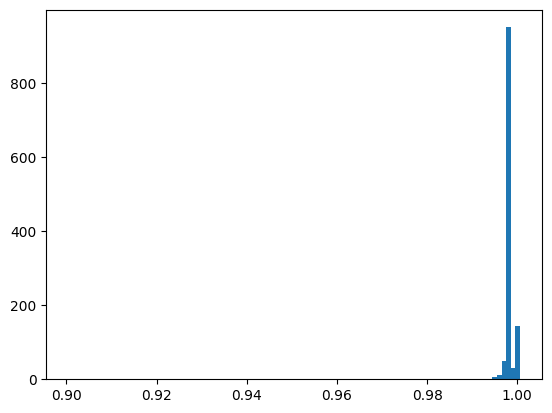

In [94]:
res = plt.bar(x,y,width=0.001)

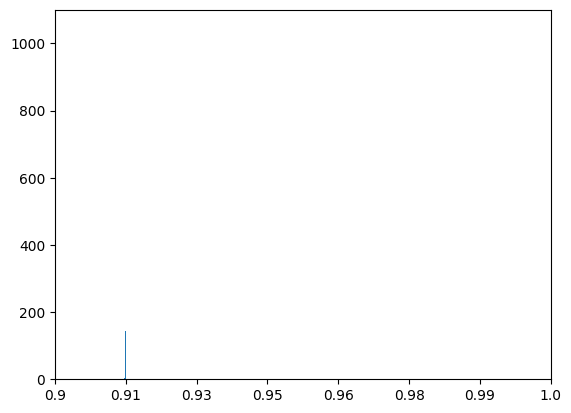

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [91]:
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(x,y,width=0.01)
ax.set_xticks(range(len(x)),sorted(x))
plt.show()
print(acc)

In [ ]:
from torchmetrics import Accuracy

In [85]:
print(acc)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
